<a href="https://colab.research.google.com/github/yordanovagabriela/neuralnetworks/blob/master/House_Prices_Clusterization_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, BatchNormalization
from keras.models import Model
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.utils.linear_assignment_ import linear_assignment
import sklearn.metrics
import seaborn as sns
from tensorflow import keras

In [183]:
dataset = pd.read_csv('./kc_house_data.csv')

del dataset['id']
del dataset['date']
del dataset['zipcode']

In [184]:
X = dataset.drop('view',axis=1)
y = dataset['view']
y.unique()

array([0, 3, 4, 2, 1])

# KMeans

In [185]:
accuracy = 0
for i in range(10):
  kmeans = KMeans(n_clusters=5, n_init=20, n_jobs=1)
  y_pred_kmeans = kmeans.fit_predict(X)
  accuracy += sklearn.metrics.accuracy_score(y.values, y_pred_kmeans)
  print("Accuracy with kMeans:", sklearn.metrics.accuracy_score(y.values, y_pred_kmeans))

Accuracy with kMeans: 0.14963216582612315
Accuracy with kMeans: 0.43543237866099105
Accuracy with kMeans: 0.43584879470688936
Accuracy with kMeans: 0.43973534446860685
Accuracy with kMeans: 0.34724471382963956
Accuracy with kMeans: 0.3469208346828298
Accuracy with kMeans: 0.4481562022856614
Accuracy with kMeans: 0.14731874334891037
Accuracy with kMeans: 0.44463980012029797
Accuracy with kMeans: 0.34696710313237406


In [186]:
accuracy / 10

0.35418960810623235

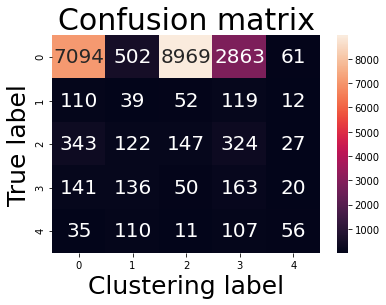

In [187]:
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred_kmeans)
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20})
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

# Autoencoders

In [188]:
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    x = BatchNormalization()(x)
    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

In [189]:
dims = [X.shape[-1], 64, 64, 5]
pretrain_optimizer = keras.optimizers.SGD(lr=0.1, momentum=0.9)
pretrain_epochs = 300
batch_size = 256

In [190]:
autoencoder, encoder = autoencoder(dims)

In [191]:
autoencoder.summary()

Model: "AE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
encoder_0 (Dense)            (None, 64)                1152      
_________________________________________________________________
encoder_1 (Dense)            (None, 64)                4160      
_________________________________________________________________
encoder_2 (Dense)            (None, 5)                 325       
_________________________________________________________________
decoder_2 (Dense)            (None, 64)                384       
_________________________________________________________________
decoder_1 (Dense)            (None, 64)                4160      
_________________________________________________________________
batch_normalization_4 (Batch (None, 64)                256      

In [192]:
scaler = sklearn.preprocessing.StandardScaler()
scaled_x = scaler.fit_transform(X)

In [193]:
scaled_x[0]

array([-0.86671733, -0.39873715, -1.44746357, -0.97983502, -0.22832133,
       -0.915427  , -0.08717263, -0.62918687, -0.55883575, -0.73470764,
       -0.65868104, -0.54489777, -0.21012839, -0.35257175, -0.30607896,
       -0.9433552 , -0.26071541])

In [194]:
autoencoder.compile(optimizer='rmsprop', loss='mean_squared_logarithmic_error')
autoencoder.fit(X, X, batch_size=64, epochs=100)

Epoch 1/100
21613/21613 [==============================] - 1s 36us/step - loss: 27.7866
Epoch 2/100
21613/21613 [==============================] - 1s 27us/step - loss: 17.4992
Epoch 3/100
21613/21613 [==============================] - 1s 27us/step - loss: 12.5200
Epoch 4/100
21613/21613 [==============================] - 1s 27us/step - loss: 9.8829
Epoch 5/100
21613/21613 [==============================] - 1s 27us/step - loss: 8.1074
Epoch 6/100
21613/21613 [==============================] - 1s 27us/step - loss: 6.7467
Epoch 7/100
21613/21613 [==============================] - 1s 28us/step - loss: 5.7421
Epoch 8/100
21613/21613 [==============================] - 1s 27us/step - loss: 4.9846
Epoch 9/100
21613/21613 [==============================] - 1s 27us/step - loss: 4.3948
Epoch 10/100
21613/21613 [==============================] - 1s 27us/step - loss: 3.9197
Epoch 11/100
21613/21613 [==============================] - 1s 27us/step - loss: 3.5430
Epoch 12/100
21613/21613 [============

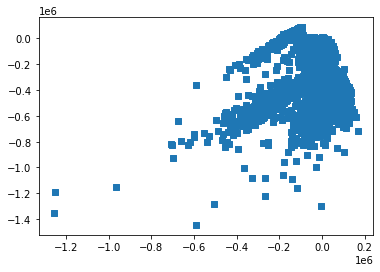

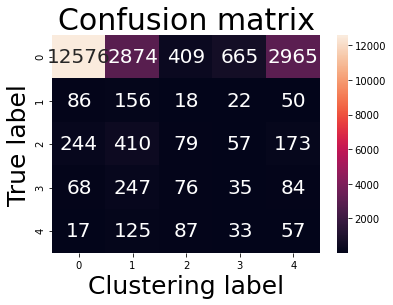

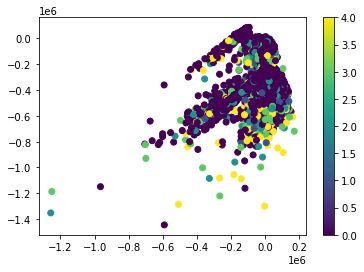

In [195]:
encoding = encoder.predict(X)

plt.scatter(encoding[:, 0], encoding[:, 1], marker="s", s=40, cmap="RdBu")
plt.show()

km = KMeans(n_clusters=5, n_init=20, n_jobs=1)

y_pred = km.fit_predict(encoding)

confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20})
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

plt.scatter(encoding[:, 0], encoding[:, 1], c=y)
plt.colorbar()
plt.show()


In [196]:
sklearn.metrics.accuracy_score(y, y_pred)

0.5970018044695322